We fetch data from http://ai.stanford.edu/~amaas/data/sentiment/.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six.moves import xrange, zip, map, filter

%matplotlib inline

In [2]:
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

def review2wordlist(review, remove_stopwords=False):
    review_text = BeautifulSoup(review, 'lxml').get_text()
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    words = review_text.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return words

In [3]:
import re 
from six.moves import xrange
import os

def get_data(file_dirs, remove_stopwords=False):
    label = []
    txt = []
    comp_re = re.compile('(\d+)_(\d+).txt')
    for file_dir in file_dirs:
        name_list = [x for x in os.listdir(file_dir) if '.txt' in x]
        for x in iter(name_list):
            f = open(os.path.join(file_dir, x), 'r')
            # word_list = review_to_wordlist(f.read(),  remove_stopwords)
            review_text = BeautifulSoup(f.read(), 'lxml').get_text()
            review_text = re.sub("[^a-zA-Z]"," ", review_text)
            txt.append(review_text)
            # txt.append(word_list)
            f.close()
            obj = comp_re.search(x)
            star = float(obj.group(2))
            if star > 5:
                label.append(1)
            else:
                label.append(0)
    return [txt, label]

In [4]:
%%time
train_unlabeled = get_data(['./aclImdb/train/unsup'], remove_stopwords=True)

CPU times: user 16.9 s, sys: 432 ms, total: 17.4 s
Wall time: 17.4 s


In [5]:
%%time
train_labeled = get_data(['./aclImdb/train/pos', './aclImdb/train/neg'], remove_stopwords=True)

CPU times: user 8.71 s, sys: 244 ms, total: 8.96 s
Wall time: 8.96 s


In [6]:
train_labeled[0][0]

u'Most reviews say that this is the weakest point in Hamilton s short movie career  This movie is a bit different from the rest  and considering it the best or the worst depends on what you expect from a movie  and what you expect from Hamilton Knowing Hamilton as a photographer  you can be slightly surprised  While Bilitis looks like his books in a movement with all those young girls discovering themselves and relations with each other on the edge of lesbian  with a plot connecting these scenes  Laura concentrates on few characters what enables developing relations among them  male female  artist model  but though we see beautiful photos  many of them better than his average  their number is reduced for the sake of the plot  Tendres cousines is different from both  it is only Hamilton s movie that looks more like a film than like a collection of moving photos  Because of that it can be acceptable to wider audience than Hamilton s fans  looking like an erotic comedy  but not German sof

# Bag of Words

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = "word", 
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 5000) 

In [16]:
from sklearn.preprocessing import normalize

def get_bow(vectorizer, data):
    bow = vectorizer.transform(data)
    bow = normalize(bow, norm='l2', axis=1)
    return bow

In [17]:
%%time

vectorizer.fit(train_labeled[0])

CPU times: user 4.62 s, sys: 68 ms, total: 4.69 s
Wall time: 4.56 s


CountVectorizer(analyzer='word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [18]:
bow = get_bow(vectorizer, train_labeled[0])

/home/tomoaki/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


In [19]:
bow.shape

(25000, 5000)

In [20]:
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D 
from keras.layers.core import Flatten, Lambda
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers.core import Dense
from keras.layers.advanced_activations import PReLU
from keras.layers import SpatialDropout2D
from keras.layers import Dropout, Reshape
from keras.layers import Embedding
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(1, activation='sigmoid', name='output', input_shape=[bow.shape[1],]))
opt = Adam(lr=1e-3)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['acc'])

In [31]:
%%time
model.fit(bow.toarray(), train_labeled[1], nb_epoch=1000, batch_size=256, verbose=2)

Epoch 1/1000
0s - loss: 0.2712 - acc: 0.9057
Epoch 2/1000
0s - loss: 0.2704 - acc: 0.9055
Epoch 3/1000
0s - loss: 0.2695 - acc: 0.9058
Epoch 4/1000
0s - loss: 0.2687 - acc: 0.9062
Epoch 5/1000
0s - loss: 0.2678 - acc: 0.9064
Epoch 6/1000
0s - loss: 0.2670 - acc: 0.9067
Epoch 7/1000
0s - loss: 0.2662 - acc: 0.9066
Epoch 8/1000
0s - loss: 0.2654 - acc: 0.9072
Epoch 9/1000
0s - loss: 0.2646 - acc: 0.9075
Epoch 10/1000
0s - loss: 0.2638 - acc: 0.9076
Epoch 11/1000
0s - loss: 0.2631 - acc: 0.9080
Epoch 12/1000
0s - loss: 0.2623 - acc: 0.9079
Epoch 13/1000
0s - loss: 0.2616 - acc: 0.9082
Epoch 14/1000
0s - loss: 0.2608 - acc: 0.9081
Epoch 15/1000
0s - loss: 0.2601 - acc: 0.9084
Epoch 16/1000
0s - loss: 0.2594 - acc: 0.9090
Epoch 17/1000
0s - loss: 0.2587 - acc: 0.9088
Epoch 18/1000
0s - loss: 0.2580 - acc: 0.9095
Epoch 19/1000
0s - loss: 0.2573 - acc: 0.9099
Epoch 20/1000
0s - loss: 0.2566 - acc: 0.9096
Epoch 21/1000
0s - loss: 0.2560 - acc: 0.9102
Epoch 22/1000
0s - loss: 0.2553 - acc: 0.91

In [22]:
%%time
test_data = get_data(['./aclImdb/test/pos', './aclImdb/test/neg'], remove_stopwords=True)
test_bow = get_bow(vectorizer, test_data[0])

CPU times: user 12.7 s, sys: 200 ms, total: 12.9 s
Wall time: 12.8 s


/home/tomoaki/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


In [32]:
output = model.predict_classes(test_bow.toarray())[:, 0]

24864/25000 [============================>.] - ETA: 0s

In [33]:
def accuracy(prediction, target):
    return 1 - np.mean(np.abs(prediction - target))

In [34]:
accuracy(output, test_data[1])

0.86607999999999996

# Word2Vec

In [8]:
def sentences2wordlist(sentences):
    return list(map(review2wordlist, sentences))

In [9]:
%%time
labeled_reviews = sentences2wordlist(train_labeled[0])

CPU times: user 6.22 s, sys: 76 ms, total: 6.29 s
Wall time: 6.32 s


In [10]:
%%time
unlabeled_reviews = sentences2wordlist(train_unlabeled[0])

CPU times: user 12.7 s, sys: 188 ms, total: 12.8 s
Wall time: 12.8 s


In [11]:
%%time
test_reviews = sentences2wordlist(test_data[0])

CPU times: user 6.48 s, sys: 96 ms, total: 6.58 s
Wall time: 6.58 s


In [12]:
%%time

from gensim.models.word2vec import Word2Vec

model = Word2Vec(unlabeled_reviews + labeled_reviews, size=300, 
                 window=5, min_count=5, workers=4, max_vocab_size=50000)

/home/tomoaki/anaconda2/lib/python2.7/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


CPU times: user 3min 29s, sys: 684 ms, total: 3min 30s
Wall time: 58.9 s


In [ ]:
def get_average_vector(word2vec, wordlist):
    wordlist = filter(lambda x: x in word2vec.vocab.keys(), wordlist)
    vectors = np.array(list(map(lambda x: word2vec[x], wordlist)))
    return np.mean(vectors, axis=0)

def sentences2avgvec(word2vec, sentences):
    return np.array(list(map(lambda x: get_average_vector(word2vec, x), sentences)))

In [ ]:
%%time
train_average_vec = sentences2avgvec(model, labeled_reviews)

In [ ]:
%%time
test_average_vec = sentences2avgvec(model, test_reviews)

In [17]:
%%time

from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100) 
forest.fit(train_average_vec, train_labeled[1])

CPU times: user 32.4 s, sys: 28 ms, total: 32.4 s
Wall time: 32.5 s


In [20]:
output = forest.predict(test_average_vec)

In [21]:
def accuracy(prediction, target):
    return 1 - np.mean(np.abs(prediction - target))

In [22]:
accuracy(output, test_data[1])

0.80855999999999995

In [1]:
from sklearn.linear_model import LogisticRegression
regr = LogisticRegression()
regr.fit(train_average_vec, train_labeled[1])

NameError: name 'train_average_vec' is not defined

# Neural Network

In [241]:
import re 
from six.moves import xrange
import os

def get_data(file_dirs, remove_stopwords=False):
    label = []
    txt = []
    comp_re = re.compile('(\d+)_(\d+).txt')
    for file_dir in file_dirs:
        name_list = [x for x in os.listdir(file_dir) if '.txt' in x]
        for x in iter(name_list):
            f = open(os.path.join(file_dir, x), 'r')
            # word_list = review_to_wordlist(f.read(),  remove_stopwords)
            # review_text = BeautifulSoup(f.read(), 'lxml').get_text()
            # review_text = re.sub("[^a-zA-Z]"," ", review_text)
            # txt.append(review_text)
            # txt.append(word_list)
            txt.append(f.read())
            f.close()
            obj = comp_re.search(x)
            star = float(obj.group(2))
            if star > 5:
                label.append(1)
            else:
                label.append(0)
    return [txt, label]

In [242]:
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import nltk

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def review_to_sentences(review, remove_stopwords=False):
    review = BeautifulSoup(review, 'lxml').get_text()
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentences) == 0:
            continue
        sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

In [243]:
%%time
train_unlabeled = get_data(['./aclImdb/train/unsup'], remove_stopwords=False)
train_labeled = get_data(['./aclImdb/train/pos', './aclImdb/train/neg'], remove_stopwords=False)

CPU times: user 312 ms, sys: 268 ms, total: 580 ms
Wall time: 577 ms


In [244]:
def get_sentnces(data):
    sentences = []
    labels = []
    ids = []
    for idx, x in enumerate(data[0]):
        _sentences = review_to_sentences(x)
        if len(_sentences) == 0:
            continue
        sentences += _sentences
        labels += [data[1][idx]] * len(_sentences)
        ids += [idx]*len(_sentences)
    return sentences, labels, ids

In [245]:
%%time
unlabeled_sentences, _, unlabeled_ids = get_sentnces(train_unlabeled)

CPU times: user 1min 47s, sys: 888 ms, total: 1min 48s
Wall time: 1min 47s


In [246]:
print(len(unlabeled_ids), len(unlabeled_sentences), len(_))

(539897, 539897, 539897)


In [247]:
import warnings

warnings.filterwarnings("ignore")

In [248]:
%%time
labeled_sentences, labeled_labels, labeled_ids = get_sentnces(train_labeled)

CPU times: user 54.2 s, sys: 616 ms, total: 54.9 s
Wall time: 54.3 s


In [249]:
length = [len(x) for x in labeled_sentences]

In [250]:
np.mean(length)

21.774692175294586

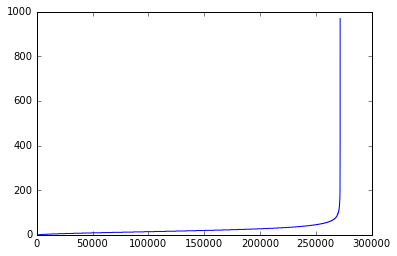

In [251]:
plt.plot(sorted(length))

In [252]:
np.median(length)

18.0

In [253]:
%%time

from gensim.models.word2vec import Word2Vec

model = Word2Vec(unlabeled_sentences + labeled_sentences, size=100, 
                 window=5, min_count=5, workers=4, max_vocab_size=50000)

CPU times: user 2min 10s, sys: 1.66 s, total: 2min 11s
Wall time: 44.7 s


In [254]:
model.most_similar('woman')

[(u'girl', 0.8241639137268066),
 (u'lady', 0.7883622646331787),
 (u'man', 0.775084376335144),
 (u'prostitute', 0.7727598547935486),
 (u'widow', 0.7150318622589111),
 (u'nun', 0.7095363736152649),
 (u'lad', 0.7027652263641357),
 (u'person', 0.6869978308677673),
 (u'housewife', 0.6725583076477051),
 (u'boy', 0.6619994044303894)]

In [20]:
model.syn0.shape

(29494, 100)

In [21]:
vocab = dict([(k, v.index) for k, v in model.vocab.items()])

In [22]:
word_list = []
for x in labeled_sentences:
    word_list += x

In [23]:
%%time

def word2index(word):
    try:
        return vocab[word]
    except:
        return None
index = map(word2index, word_list)

CPU times: user 9 µs, sys: 1 µs, total: 10 µs
Wall time: 39.8 µs


In [24]:
index

In [147]:
weights = model.syn0
np.save(open("embbeding.npy", 'wb'), weights)

In [146]:
from keras.layers import Embedding, Input

def w2v_embedding_layer(embeddings_path):
    weights = np.load(open(embeddings_path, 'rb'))
    layer = Embedding(input_dim=weights.shape[0], 
                      output_dim=weights.shape[1], 
                      weights=[weights])
    return layer

Using TensorFlow backend.


In [175]:
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D 
from keras.layers.core import Flatten, Lambda
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers.core import Dense
from keras.layers.advanced_activations import PReLU
from keras.layers import SpatialDropout2D
from keras.layers import Dropout, Reshape
from keras.layers import Embedding
from keras.optimizers import Adam
from keras import backend as K
import numpy as np
import pandas as pd
import time
from gensim.models.word2vec import Word2Vec

class CNN(object):
    def __init__(self, conf, sentences):
        self.model_config = conf.model_config
        self.n_emb = conf.n_emb
        self.min_word_count = conf.min_word_count
        self.n_context = conf.n_context
        self.n_workers = 4
        self.algo = conf.algo
        self.n_epoch = conf.n_epoch
        self.batch_size = conf.batch_size
        self.maxlen = conf.maxlen
        self.learning_rate = conf.learning_rate
        
        print("build word2vec ...")
        self.word2vec = Word2Vec(sentences, workers=self.n_workers, 
            size=self.n_emb, min_count = self.min_word_count, 
            window = self.n_context, sg=self.algo)
        print("finished!")
        
        self.vocab = dict([(k, v.index) for k, v in self.word2vec.vocab.items()])
        self.n_vocab = len(self.vocab)
        index = self.word2indexes(sentences)
        
        # avoid creating _LEARNING_PHASE outside the network
        tf.reset_default_graph()
        K.clear_session()
        self.sess = tf.Session()
        print("buiild model ...")
        self.build_model()
        print("finished")
        
    def train(self, input_data, target_data):
        print("start training")
        index_data = self.word2indexes(input_data)
        self.model.fit(index_data, target_data, nb_epoch=self.n_epoch, batch_size=self.batch_size)
        print("finished")
        
    def predict(self, input_data):
        index_data = self.word2index(input_data)
        return self.model.predict(index_data)
    
    def word2index(self, sentence):
        def w2i(x):
            try:
                return self.vocab[x]
            except:
                return None
        index = map(w2i, sentence)
        index = filter(lambda x: x is not None, index)
        return list(index)
    
    def word2indexes(self, sentences):
        index = map(self.word2index, sentences)
        return pad_sequences(list(index), maxlen=self.maxlen)
    
    def build_model(self):
        self.input = tf.placeholder(tf.int32, [None, self.maxlen], name="input")
        model = Sequential()
        model.add(Embedding(input_dim=self.n_vocab, output_dim=self.n_emb, 
                            input_length=self.maxlen, name="embedding", weights=[self.word2vec.syn0]))
        model.add(Reshape([self.maxlen, self.n_emb, 1]))
        self.model = self.build_network(self.model_config, model=model)
        
        self.output = self.model(self.input)
        opt = Adam(lr=self.learning_rate)
        self.model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['acc'])
    
    def build_network(self, conf, model=None, input_shape=None, is_conv=True):
        """Build network"""
        _model = model
        model = Sequential()
        if _model is None:
            model.add(Lambda(lambda x: x,  input_shape=input_shape))
        else:
            model.add(_model)
            
        for x in conf:
            if x['is_drop']:
                model.add(Dropout(x['drop_rate']))
                
            if x['type'] is 'full':
                if is_conv:
                    model.add(Flatten())
                    is_conv = False
                model.add(Dense(x['n_feature']))
            elif x['type'] is 'conv':
                model.add(Convolution2D(nb_filter=x['n_feature'], 
                                        nb_row=x['kw'], 
                                        nb_col=1, 
                                        border_mode='same'))  
                is_conv=True
                
            if x['is_batch']:
                if x['type'] is 'full':
                    model.add(BatchNormalization(mode=1, axis=-1))
                if x['type'] is 'conv':
                    model.add(BatchNormalization(mode=2, axis=-1))
            
            if x['activation'] is None:
                pass
            if x['activation'] is 'prelu':
                model.add(PReLU())
            else:
                model.add(Activation(x['activation']))
            
            if type(x['n_pool']) is int:
                model.add(MaxPooling2D(pool_size=(x['n_pool'], 1), border_mode='same'))
        return model

In [188]:
class Config(object):
    device = '/gpu:0'
    save_path = '/home/tomoaki/work/github/jjakimoto.github.io/content'
    is_load = False
    n_batch = 32
    n_epoch = 10
    learning_rate = 1e-4
    n_emb = 100
    min_word_count = 5
    n_context = 10
    n_worker = 4
    algo = 1
    batch_size = 256
    maxlen = 20
    
    model_config = [{'type':'conv', 'n_feature': 32, 'kw': 5,
                    'activation': 'prelu', 'is_batch': True, 'is_drop': False,
                    'n_pool': None},
                    {'type':'conv', 'n_feature': 64, 'kw': 5,
                    'activation': 'prelu', 'is_batch': True, 'is_drop': False,
                    'n_pool': 2},
                    {'type':'conv', 'n_feature': 64, 'kw': 5,
                     'activation': 'prelu', 'is_batch': True, 'is_drop': False,
                    'n_pool': 2},
                    {'type':'full', 'n_feature': 32, 'kw': 4,
                    'activation': 'prelu', 'is_batch': True, 'is_drop': False,
                    'n_pool': None},
                    {'type':'full', 'n_feature': 1, 'kw': 4,
                     'activation': 'sigmoid', 'is_batch': False, 'is_drop': False,
                    'n_pool': None}]

In [189]:
conf = Config()
# cnn = CNN(conf, labeled_sentences + unlabeled_sentences)
cnn = CNN(conf, labeled_sentences)
cnn.train(labeled_sentences, labeled_labels)

build word2vec ...
finished!
buiild model ...
finished
start training
Epoch 1/10
271908/271908 [==============================] - 249s - loss: 0.6145 - acc: 0.6544   
Epoch 2/10
271908/271908 [==============================] - 249s - loss: 0.5692 - acc: 0.6984   
Epoch 3/10
271908/271908 [==============================] - 253s - loss: 0.5451 - acc: 0.7179   
Epoch 4/10
271908/271908 [==============================] - 249s - loss: 0.5216 - acc: 0.7353   
Epoch 5/10
271908/271908 [==============================] - 251s - loss: 0.4956 - acc: 0.7553   
Epoch 6/10
271908/271908 [==============================] - 251s - loss: 0.4663 - acc: 0.7751   
Epoch 7/10
271908/271908 [==============================] - 251s - loss: 0.4335 - acc: 0.7957   
Epoch 8/10
113408/271908 [===========>..................] - ETA: 145s - loss: 0.3923 - acc: 0.8202

KeyboardInterrupt: 

In [83]:
word


0

In [2]:
sys.path

['',
 '/Users/admin/pokemon/PokemonGo-Bot/src/pgoapi',
 '/Users/admin/anaconda/lib/python35.zip',
 '/Users/admin/anaconda/lib/python3.5',
 '/Users/admin/anaconda/lib/python3.5/plat-darwin',
 '/Users/admin/anaconda/lib/python3.5/lib-dynload',
 '/Users/admin/anaconda/lib/python3.5/site-packages',
 '/Users/admin/anaconda/lib/python3.5/site-packages/Sphinx-1.3.5-py3.5.egg',
 '/Users/admin/anaconda/lib/python3.5/site-packages/aeosa',
 '/Users/admin/anaconda/lib/python3.5/site-packages/IPython/extensions',
 '/Users/admin/.ipython']

In [3]:
!which python


/Users/admin/anaconda/bin/python


In [4]:
import os
os.environ['PYTHONPATH'].split(os.pathsep)

KeyError: 'PYTHONPATH'

In [69]:


def f(x):
    if x == 2:
        return None
    else:
        return x

index = map(f, [[1, 2, 3, 4], [2, 4, 5, 6]])
print(list(index))

[[1, 2, 3, 4], [2, 4, 5, 6]]


In [66]:
y = filter(lambda x: x is not None, index)

In [67]:
np.array(list(y))

array([[1, 2, 3, 4],
       [2, 4, 5, 6]])

In [105]:
vocab = dict([(k, v.index) for k, v in model.vocab.items()])

In [107]:
vocab['fury']

4964

In [108]:
sample = labeled_sentences[:100]

In [124]:
index = map(lambda x: vocab[x], sample[0])

In [130]:
def w2v(word):
    try:
        return vocab[word]
    except:
        return None

In [131]:
index = map(w2v, sample[0])

In [132]:
list(index)

[None, 299, 5, 2, 1073, 200]

In [123]:
len(vocab)

29494

In [163]:
x = np.arange(100000000)

In [165]:
%%time
y = [t**2 for t in x]

CPU times: user 28.3 s, sys: 7.16 s, total: 35.5 s
Wall time: 36.8 s


In [166]:
%%time
y = map(lambda t: t**2, x)

CPU times: user 1.47 s, sys: 3.68 s, total: 5.14 s
Wall time: 5.45 s
